In [22]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


# Eccentricity $e (\xi_{\phi})$

In [23]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [24]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [25]:
#def xi(x):
   # return x**(3/2)

#def xconv(f,M)

# Hybrids

In [26]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [27]:
hfile = ['1371hyb_EccTD_xlow045_GM.h5']  #hybrids
l0 = 0.665
#xref = 0.075
x0 = 0.045
e0 = 0.142
q = 3
eta = q/(1+q)**2

f0 = 20

In [28]:
for i in range(0,len(hfile)):
    hyb_name = hfile[i][0:4]
    f=h5py.File(hfile[i],'r')
    data=f['l2_m2']
    tVec=real(data[0:,0])
    h22pVec=real(data[0:,1])
    h22cVec=real(data[0:,2])
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    hpVec=h22pVec
    hcVec=h22cVec
    
    tVec=tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
    M=40
    M1=q*M/(1+q)
    M2=M/(1+q)
    q0=q
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    tVec=tVec*M*MTSUN_SI
    hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    tVec = tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
    
    delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
    
    fref = 0.075**(3/2) /MTSUN_SI/ PI/M
    fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
    
    hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t,f_lower=fmin, eccentricity=e0)
    #m(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, mode_array=[[2,2],[2,1],[3,3],[3,2],[4,4],[4,3],[5,5]])
    sp, sc = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin,inclination=0.3488, mode_array=[[5,5]])
    
    
    #EDIT BY PRATUL
    tEber=np.loadtxt('formodel55.txt')[:,0]*(M*MTSUN_SI)
    h22Eber=np.loadtxt('formodel55.txt')[:,1]*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    
    
    
    tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    #tmin = max(tVec[0],hp.sample_times[0]-tshift,sp.sample_times[0]) # ??Need to understand
    tmin = max(tVec[0],hp.sample_times[0]-tshift,sp.sample_times[0]) #EDIT
    
    plotband = np.where(tVec>=tmin)[0][0]
    hpVec = hpVec[plotband:]
    hcVec = hcVec[plotband:]
    tVec= tVec[plotband:]
    
    h22Hyb=hpVec+1j*hcVec
    tVec=tVec - tVec[np.argmax(abs(h22Hyb))] # Shifting peak to zero
    phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
    omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))
    
    # CIRCULAR IMR INTERP1D
    sp_intrp = interp1d(sp.sample_times,sp, kind='cubic',fill_value='extrapolate')
    sc_intrp = interp1d(sc.sample_times,sc, kind='cubic',fill_value='extrapolate')
    tImr_intrp=np.arange(tmin, sp.sample_times[-1], delta_t)
    sp_intrp=sp_intrp(tImr_intrp)
    sc_intrp=sc_intrp(tImr_intrp)
    tImr = tImr_intrp
    hpImr = sp_intrp
    hcImr = sc_intrp
    h22Imr=hpImr+1j*hcImr
    
    tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    
    #ECCTD INTERP1D
    hp_intrp=interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp=interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
    
    tEcc_intrp=np.arange(tmin,hp.sample_times[-1]-tshift, delta_t) #Need to know ????
    hp_intrp=hp_intrp(tEcc_intrp)
    hc_intrp=hc_intrp(tEcc_intrp)
    tEcc=tEcc_intrp
    hpEcc=hp_intrp
    hcEcc=hc_intrp
    h22Ecc=hpEcc+1j*hcEcc
    
    phaseEcc=np.unwrap(np.angle(h22Ecc)*2)/2
    phaseImr = np.unwrap(np.angle(h22Imr)*2)/2
    
    #Matching initial phase
    dphase = phaseEcc[0]-phaseImr[0]
    hp_new=real(h22Ecc*exp(-1j*dphase))
    hc_new=imag(h22Ecc*exp(-1j*dphase))
    
    phase_new=np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2
    phaseEcc=phase_new
    h22Ecc_new=hp_new+1j*hc_new
    
  #EDIT BY PRATUL
    h22Eber_intrp=interp1d(tEber,h22Eber, kind='cubic',fill_value='extrapolate')
    tEber_intrp=np.linspace(tEber[0],tEber[-1],29826)
    h22Eber_intrp=h22Eber_intrp(tEber_intrp)
    #arg=np.argmin(abs(tEcc-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
    arg=np.argmin(abs(tEber_intrp-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI)) #EDIT
    Idxjoin=arg
    
    t_amp=tamp_Hinsp(eta,e0,l0) - 500
    #idxstr=np.argmin(abs(tEcc-t_amp*M*MTSUN_SI))
    idxstr=np.argmin(abs(tEber_intrp-t_amp*M*MTSUN_SI)) #EDIT
    
    
  
    
    
    
    
    #Amp model
    amp=[]
    count=0
    length=Idxjoin-idxstr
    
    for i in range(idxstr,Idxjoin):
        #amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
        amp.append(((length-count)*h22Eber_intrp[i]+count*abs(h22Imr[i]))/length) #EDIT
        count=count+1
        
    #t_model=np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
    t_model=np.concatenate((tEber_intrp[0:Idxjoin],tImr[Idxjoin:len(tImr)])) #EDIT
    #h22amp=np.concatenate((abs(h22Ecc_new[0:idxstr]),amp)) #EDIT
    h22amp=np.concatenate((abs(h22Eber_intrp[0:idxstr]),amp)) #EDIT
    h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
    
    #omegaEcc=(M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
    #omegaImr=(M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
    
    #tjoin0=tfreq_Hinsp(eta,e0,l0)
    #tjoin=tjoin0*M*MTSUN_SI
    #fjoin=np.argmin(abs(tEcc-tjoin))
    
    #Frequency model
    #tstop = min(tEber[-1],-30*M*MTSUN_SI)
    #lst = np.argmin(abs(tEcc-tstop))

    #lst = len(tEcc)

    #indx = lst - fjoin
    #a0 = []
    #n = indx - 1 
    #k = 0
    #for i in range(fjoin,fjoin+indx):   #fjoin - 500
        #a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
        #k = k+1

    #f1 = np.concatenate((omegaEcc[0:fjoin],a0))
    #frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
    #phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t) + PI/1.4#PI/2.1#PI/0.1#


    #hp_f_model = h22amp_model * np.cos(phase_f_model)

In [29]:
print(Idxjoin,idxstr,len(h22Imr),len(h22Eber),len(sp.sample_times),len(h22Eber_intrp))
delta_t = delta_t_NR = np.abs(np.mean((np.diff(tEber))))
print(delta_t)

29746 28976 30308 100050 33000 29826
3.814697265625001e-05


In [30]:
#plt.figure(figsize=(10,4.8))
#plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='navajowhite',linewidth=6,alpha = 1,label='hybrid',zorder=1)
#plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
#plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
#plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)

#plt.xlim(xmin=-4500)
#plt.xlim(xmax=100)
#plt.ylim(ymin=2.5e-2)
#plt.ylim(ymax=3e-1)
#plt.ylabel(r'$M \omega_{22}$',fontsize=22,labelpad=5)
#plt.xlabel(r'$t/M$',fontsize=22)
#plt.text(-3110,6e-2,r'$t_{\rm{match}}$',fontsize=18)
#plt.yscale('log')
#plt.legend()
#plt.savefig('freq_model.png',dpi=300)

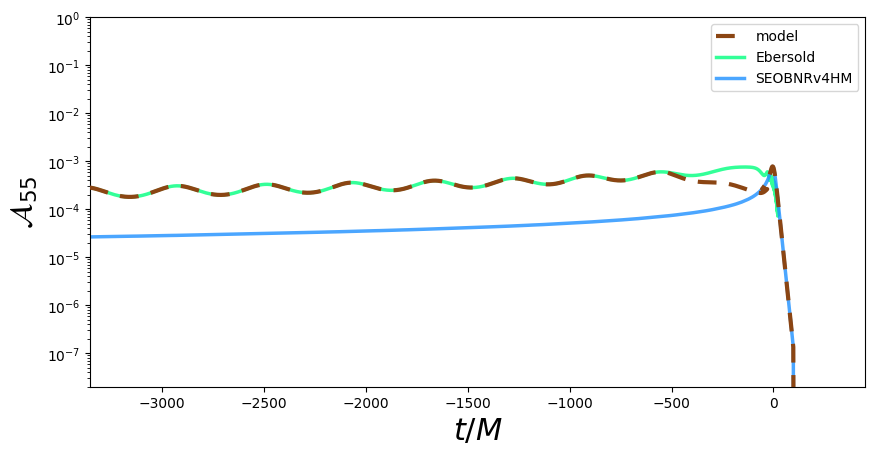

In [31]:
plt.figure(figsize=(10,4.8))
#plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=6,alpha = 1,label='hybrid',zorder=1)
plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
plt.plot(tEber/(M*MTSUN_SI),h22Eber/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)
#plt.xlim(xmin=-1200)
#plt.xlim(xmax=100)
#plt.ylim(ymax=4.5e-1)
#plt.ylim(ymin=3e-2)

plt.ylim(ymax=1e0)
plt.ylim(ymin=2e-8)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)
plt.ylabel(r'$\mathcal{A}_{55}$',fontsize=22,labelpad=5)
plt.xlabel(r'$t/M$',fontsize=22)
plt.yscale('log')
plt.legend()
plt.savefig('amp20_model55.png',dpi=300)
#np.savetxt('HM33.txt',np.c_[t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)])